In [1]:
import cv2
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from skimage.exposure import equalize_adapthist, equalize_hist, rescale_intensity
from skimage.util import img_as_ubyte, img_as_float
from skimage.color import *

In [2]:
def calibrate_camera():
    nx = 9
    ny = 6
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Get image shape
    img_shape = plt.imread('camera_cal/calibration1.jpg').shape[0:2]
    img_shape = {'x': img_shape[1], 'y': img_shape[0]}
    
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = 'camera_cal/corners_found/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
    
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img_shape['x'], img_shape['y']), None, None)
    return ret, mtx, dist, rvecs, tvecs

In [3]:
def convert_to_grayscale(img, in_type = ''):
    assert in_type in ['HSV', 'HLS', 'RGB', 'BGR']
    if in_type == 'HSV':
        img_gray = cv2.cvtColor(img, cv2.COLOR_HSV2GRAY)
    elif in_type == 'HLS':
        img_gray = cv2.cvtColor(img, cv2.COLOR_HLS2GRAY)
    elif in_type == 'RGB':
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif in_type == 'BGR':
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

def get_RGB_channels(img):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    
    return R,G,B

def get_HLS_channels(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = img[:,:,0]
    L = img[:,:,1]
    S = img[:,:,2]
    
    return H, L, S

In [4]:
def sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    thresh_max = thresh[1]
    thresh_min = thresh[0]
    
    # Ensure img is grayscale
    assert orient in ['x','y']
    if len(img.shape) == 3:
        assert img.shape[2] == 1
    
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    
    elif orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sobel_binary

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Calculate directional gradient
    thresh_max = thresh[1]
    thresh_min = thresh[0]
    
    if len(img.shape) == 3:
        assert img.shape[2] == 1
        
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    gradient_mag = np.sqrt(sobelx**2+sobely**2)
    scale_factor = np.max(gradient_mag)/255
    gradient_mag = (gradient_mag/scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(gradient_mag)
    mag_binary[(gradient_mag > thresh_min) & (gradient_mag < thresh_max)] = 1
    
    return mag_binary

def dir_thresh(img, sobel_kernel=3, thresh=(-np.pi/2, np.pi/2)):
    # Calculate gradient direction
    thresh_max = thresh[1]
    thresh_min = thresh[0]
    
    if len(img.shape) == 3:
        assert img.shape[2] == 1
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir > thresh_min) & (grad_dir < thresh_max)] = 1
    
    return dir_binary

In [5]:
def get_binary(img, thresh = (0,255)):
    
    binary = np.zeros_like(img)
    
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    
    return binary

In [95]:
def get_perspective_transform():
    #straight_lines = plt.imread('test_images/straight_lines2.jpg')
    #straight_lines = convert_to_grayscale(straight_lines, in_type = 'RGB')
    #straight_lines = cv2.undistort(straight_lines, mtx, dist, None, mtx)
    #straight_lines_drawn = cv2.undistort(plt.imread('test_images/straight_lines2.jpg'), mtx, dist, None, mtx)
    BL = [265, 680]
    BR = [1043, 680]
    UL = [558, 477]
    UR = [726, 476]

    src = np.float32([BL, UL, BR, UR])
    dst = np.float32([[320, 720], [320, 0], [960,720], [960,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    
    return M

def perspective_transform(img, M):
    img_transformed = cv2.warpPerspective(img, M, dsize = (1280, 720))
    
    return img_transformed

In [96]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera()

In [97]:
persp1 = plt.imread('test_images/straight_lines1_undistorted.png')
persp2 = plt.imread('test_images/straight_lines2_undistorted.png')

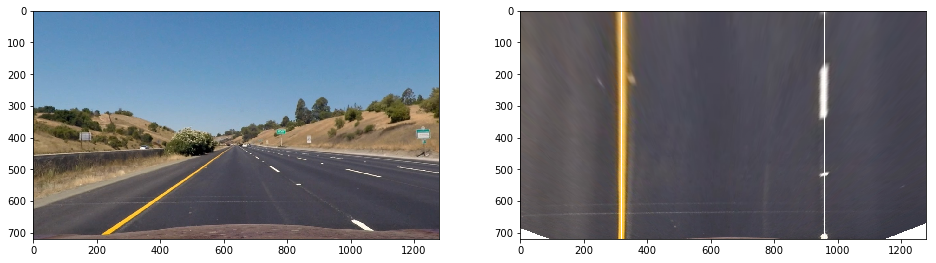

In [98]:
color1 = (255,0,0)
thickness1 = 3

M = get_perspective_transform()
persp1_warped = perspective_transform(persp1, M)
persp2_warped = perspective_transform(persp2, M)
cv2.line(persp1_warped, (320,720), (320,0), color1, thickness1)
cv2.line(persp1_warped, (960,720), (960,0), color1, thickness1)
cv2.line(persp2_warped, (320,720), (320,0), color1, thickness1)
cv2.line(persp2_warped, (960,720), (960,0), color1, thickness1)
f, (ax1, ax2) = plt.subplots(1,2,figsize = (16,9))
ax1.imshow(persp1)
ax2.imshow(persp1_warped)

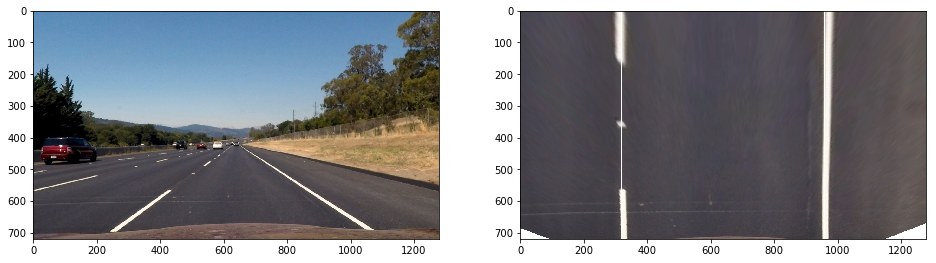

In [99]:
cv2.line(persp2_warped, (320,720), (320,0), (255,0,0), 3)
cv2.line(persp2_warped, (960,720), (960,0), (255,0,0), 3)
f, (ax1, ax2) = plt.subplots(1,2,figsize = (16,9))
ax1.imshow(persp2)
ax2.imshow(persp2_warped)

In [100]:
img_name = 'test1'

/home/ucalegon/pythoconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/home/ucalegon/pythoconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


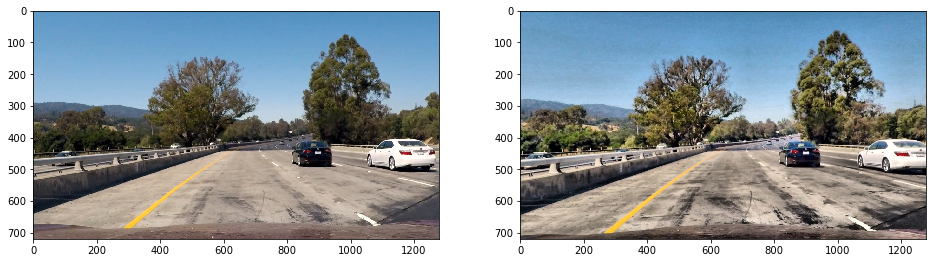

In [101]:
test_image = plt.imread('test_images/{}.jpg'.format(img_name))
#test_image = convert_to_grayscale(test_image, in_type = 'RGB')
undistorted = cv2.undistort(test_image, mtx, dist, None, mtx)
undistorted = img_as_ubyte(equalize_adapthist(undistorted))
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,9))
ax1.imshow(test_image, cmap = 'gray')
ax2.imshow(undistorted, cmap = 'gray')

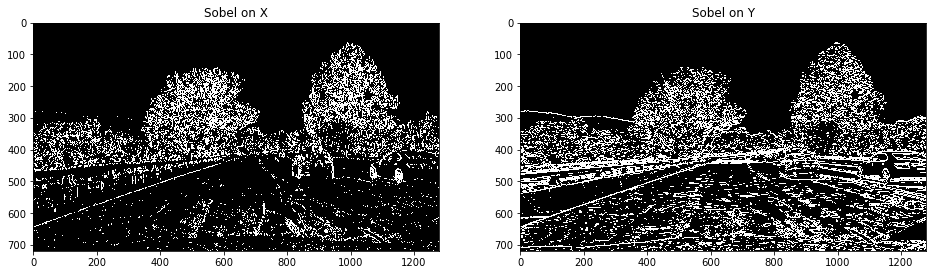

In [102]:
threshx = (20, 255)
threshy = (20, 255)
sobelx = sobel_thresh(convert_to_grayscale(undistorted, in_type = 'RGB'), orient = 'x', thresh = threshx)
sobely = sobel_thresh(convert_to_grayscale(undistorted, in_type = 'RGB'), orient = 'y', thresh = threshy)
f, (ax1, ax2) = plt.subplots(1,2,figsize = (16,9))
ax1.imshow(sobelx, cmap = 'gray')
ax1.set_title('Sobel on X')
ax2.imshow(sobely, cmap = 'gray')
ax2.set_title('Sobel on Y')

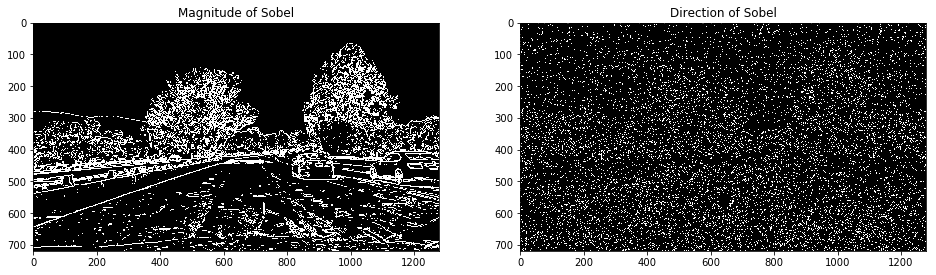

In [103]:
threshmag = (30, 255)
mag = mag_thresh(convert_to_grayscale(undistorted, in_type = 'RGB'), thresh = threshmag)
threshdir = (0.9, 1.1)
dirt = dir_thresh(convert_to_grayscale(undistorted, in_type = 'RGB'), thresh = threshdir)

f, (ax1, ax2) = plt.subplots(1,2,figsize = (16,9))
ax1.imshow(mag, cmap = 'gray')
ax1.set_title('Magnitude of Sobel')
ax2.imshow(dirt, cmap = 'gray')
ax2.set_title('Direction of Sobel')

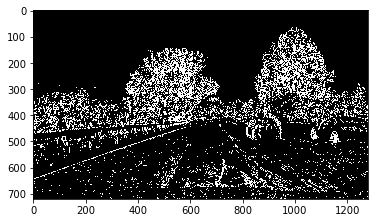

In [104]:
combined = np.zeros_like(mag)
combined[(sobelx==1) | ((sobely == 1) & (dirt == 1))] = 1
plt.imshow(combined, cmap = 'gray')

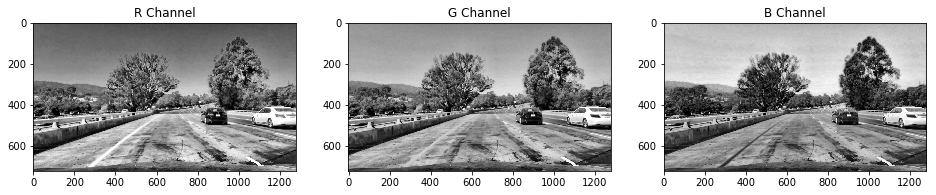

In [105]:
R,G,B = get_RGB_channels(undistorted)
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16,9))
ax1.imshow(R, cmap = 'gray')
ax1.set_title('R Channel')
ax2.imshow(G, cmap = 'gray')
ax2.set_title('G Channel')
ax3.imshow(B, cmap = 'gray')
ax3.set_title('B Channel')

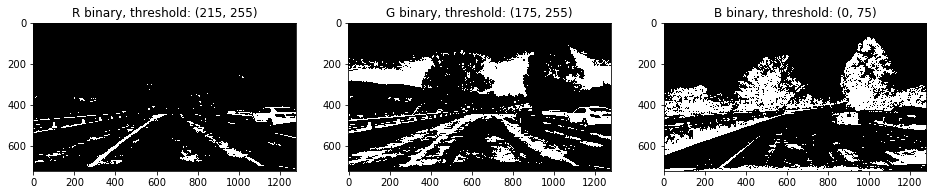

In [106]:
R_thresh = (215,255)
G_thresh = (175,255)
B_thresh = (0,75)
R_binary = get_binary(R, thresh = R_thresh)
G_binary = get_binary(G, thresh = G_thresh)
B_binary = get_binary(B, thresh = B_thresh)
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (16,9))
ax1.imshow(R_binary, cmap = 'gray')
ax1.set_title('R binary, threshold: {}'.format(R_thresh))
ax2.imshow(G_binary, cmap = 'gray')
ax2.set_title('G binary, threshold: {}'.format(G_thresh))
ax3.imshow(B_binary, cmap = 'gray')
ax3.set_title('B binary, threshold: {}'.format(B_thresh))

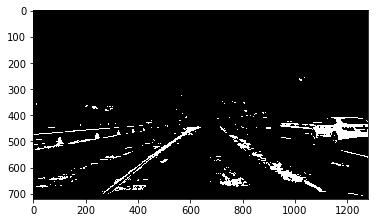

In [107]:
RGB_combined = np.zeros_like(R_binary)
RGB_combined[(R_binary == 1) & ((G_binary == 1) != (B_binary ==1))] = 1
plt.imshow(RGB_combined, cmap = 'gray')

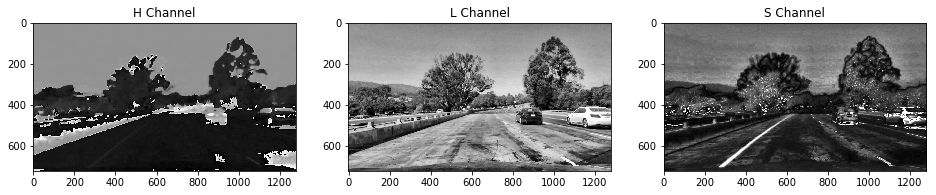

In [108]:
H,L,S = get_HLS_channels(undistorted)
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16,9))
ax1.imshow(H, cmap = 'gray')
ax1.set_title('H Channel')
ax2.imshow(L, cmap = 'gray')
ax2.set_title('L Channel')
ax3.imshow(S, cmap = 'gray')
ax3.set_title('S Channel')

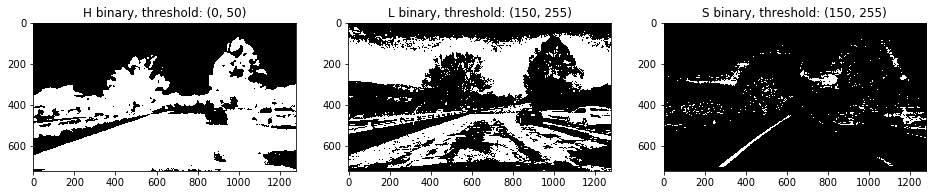

In [109]:
H_thresh = (0,50)
L_thresh = (150,255)
S_thresh = (150,255)
H_binary = get_binary(H, thresh = H_thresh)
L_binary = get_binary(L, thresh = L_thresh)
S_binary = get_binary(S, thresh = S_thresh)
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (16,9))
ax1.imshow(H_binary, cmap = 'gray')
ax1.set_title('H binary, threshold: {}'.format(H_thresh))
ax2.imshow(L_binary, cmap = 'gray')
ax2.set_title('L binary, threshold: {}'.format(L_thresh))
ax3.imshow(S_binary, 'gray')
ax3.set_title('S binary, threshold: {}'.format(S_thresh))

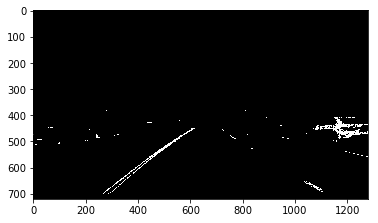

In [110]:
final_binary = np.zeros_like(S_binary)
final_binary[(RGB_combined == 1) & (S_binary == 1)] = 1
plt.imshow(final_binary, cmap = 'gray')

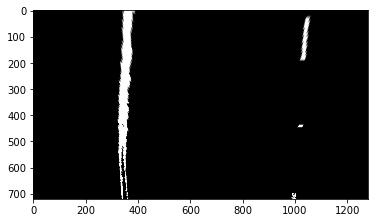

In [111]:
color = (255,0,0)
thickness = 3
M = get_perspective_transform()
binary_warped = perspective_transform(final_binary*255, M)
#binary_warped = gray2rgb(binary_warped)
#cv2.line(binary_warped, (320,720), (320,0), color, thickness)
#cv2.line(binary_warped, (960,720), (960,0), color, thickness)
plt.imshow(binary_warped, cmap = 'gray')


In [112]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[3*binary_warped.shape[0]//4:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 128
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,0,255), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(255,0,255), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


(720, 0)

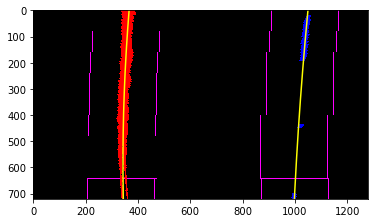

In [113]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

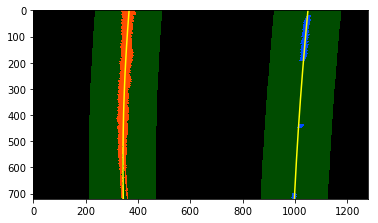

In [114]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [116]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

1740.65828794 1860.4253841


In [117]:
len(ploty)

720

In [118]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

571.503929391 m 610.630092059 m
